In [1]:
#import all necessary modules needed
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision import datasets
import numpy as np
from torchvision import utils
from torch import nn

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

#downloading the CIFAR10 dataset
train_set = datasets.CIFAR10(root='./data', train=True,
                             download=True, transform=transform)

test_set = datasets.CIFAR10(root='./data', train=False,
                            download=True, transform=transform)

# limit the dataset to the the first 45k samples
train_set = list(train_set)[:45000]
#split the dataset
train_set, val_data = random_split(train_set, [35000, 10000])


#setting up the data loaders for each dataset
train_loader = DataLoader(train_set, batch_size=batch_size,
                          shuffle=True, num_workers=0)

test_loader = DataLoader(test_set, batch_size=batch_size,
                        shuffle=False, num_workers=0)

val_loader = DataLoader(val_data, batch_size=batch_size,
                        shuffle=False, num_workers=0)


#define classes of images in the dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 48826333.99it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


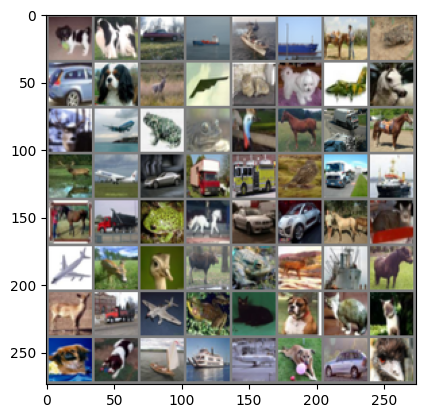

dog   dog   car   ship  ship  ship  horse frog  car   dog   deer  plane cat   dog   plane horse deer  plane frog  frog  bird  horse truck horse deer  plane car   truck truck bird  truck ship  horse truck frog  horse car   car   horse cat   plane deer  bird  deer  frog  deer  ship  horse deer  truck plane frog  cat   dog   cat   cat   dog   dog   ship  ship  plane dog   car   bird 


In [3]:
#display some training images

#functions to show an image
#code adapted from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


def imshow(img):
    img = img / 2 + 0.5     #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


#get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

#show images
imshow(utils.make_grid(images))
#print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
#building a custom softmax module
class Softmax(nn.Module):
  def __init__(self, n_inputs, n_outputs):
    super(Softmax, self).__init__()
    self.linear = torch.nn.Linear(n_inputs, n_outputs)

  def forward(self, x):
    pred = self.linear(x)
    return pred

In [10]:
from typing_extensions import dataclass_transform
from functools import total_ordering
from sklearn.metrics import classification_report

#building a function to train the network
def training(model, train_loader, val_loader, criterion, epochs, optimizer):
  model.train()

  """
  Author: Aondokator Joseph
  I just used the main ideas found in the pytorch documentation
  and other tutorials
  """
  final_training_loss = 0.0
  final_training_acc = 0.0
  final_val_loss = 0.0
  final_val_acc = 0.0

  for epoch in range(epochs):
      running_loss = 0.0
      correct = 0
      total = 0

      for i, (images, labels) in enumerate(train_loader, 0):

        images, labels = images.to(device), labels.to(device) #send images and labels to the device
        optimizer.zero_grad()

        # froward pass
        outputs = model(images.view(-1, 32*32*3))
        loss = criterion(outputs, labels)

        #backward pass and optimization
        loss.backward()
        optimizer.step()

        #print out the statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

      training_acc = 100 * correct/total
      final_training_loss += running_loss / len(train_loader)
      final_training_acc += training_acc

      model.eval()
      val_loss = 0
      val_correct = 0
      val_total = 0


      val_labels = []
      val_predictions = []

      #validation loop
      with torch.no_grad():
        for images, labels in val_loader:
          images, labels = images.to(device), labels.to(device) # send to device
          outputs = model(images.view(-1, 32*32*3))
          loss = criterion(outputs, labels) # calculate validation loss
          val_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          val_total += labels.size(0)
          val_correct += (predicted == labels).sum().item()


          # collecting true and predicted labels for classification report
          val_labels.extend(labels.cpu().numpy()) #chatGPT suggestion
          val_predictions.extend(predicted.cpu().numpy()) #chatGPT suggestion


      #calculating validation accuracy
      val_acc = 100 * val_correct / val_total
      final_val_loss += val_loss / len(val_loader)
      final_val_acc += val_acc

     # Print final loss and accuracy after all epochs
  print(f'Final Training Loss: {final_training_loss / epochs:.4f}')
  print(f'Final Training Accuracy: {final_training_acc / epochs:.2f}%')
  print(f'Final Validation Loss: {final_val_loss / epochs:.4f}')
  print(f'Final Validation Accuracy: {final_val_acc / epochs:.2f}%')


  return model, training_acc, val_acc


In [11]:
def main_test(model, data_loader):
  model.eval()
  test_correct = 0
  test_total = 0
  test_labels = [] #store true labels
  test_predictions = [] #store predicted labels

  with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images.view(-1, 32 * 32 * 3))
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        test_labels.extend(labels.cpu().numpy()) #chatGPT suggestion
        test_predictions.extend(predicted.cpu().numpy()) #chatGPT suggestion

  test_acc = 100 * test_correct / test_total
  print(f'Test Accuracy: {test_acc:.2f} %')

  return test_acc

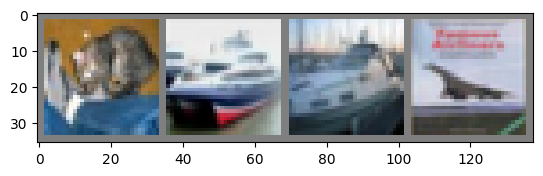

GroundTruth:  cat   ship  ship  plane


In [12]:
#testing the network on our test data set
def not_maintest(test_loader):
  dataiter = iter(test_loader) #iterate over the test data set
  images, labels = next(dataiter) # go to the next image this does not require a for loop

  # print the images
  images = images[:4]
  labels = labels[:4]
  imshow(utils.make_grid(images))
  print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

not_maintest(test_loader)

In [14]:
# defining our loss function and optimizer
import torch.optim as optim
import torch.nn as nn

#defining the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#defining the model
def get_model():
  model = Softmax(3072, 10).to(device)
  return model

criterion = nn.CrossEntropyLoss()

weight_decays = [0, 1e-4, 1e-3, 1e-2] #suggested by chatGPT
for weight_decay in weight_decays:
  model = get_model() #reset the model after each iteration
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=weight_decay)

  #calling the function
  epochs = 200
  model, training_accuracy, val_acc = training(model, train_loader, val_loader, criterion,
                 epochs, optimizer)

  test_accuracy = main_test(model, test_loader)
  train_accuracy = main_test(model, train_loader)
  val_acc = main_test(model, val_loader)

  print(f'Weight Decay: {weight_decay}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_acc:.2f}%, Test Accuracy: {test_accuracy:.2f}%\n')

Final Training Loss: 1.5787
Final Training Accuracy: 46.57%
Final Validation Loss: 1.7616
Final Validation Accuracy: 39.47%
Test Accuracy: 38.59 %
Test Accuracy: 38.59 %
Test Accuracy: 38.59 %
Weight Decay: 0, Training Accuracy: 38.59%, Validation Accuracy: 38.59%, Test Accuracy: 38.59%

Final Training Loss: 1.5801
Final Training Accuracy: 46.56%
Final Validation Loss: 1.7594
Final Validation Accuracy: 39.52%
Test Accuracy: 38.79 %
Test Accuracy: 38.79 %
Test Accuracy: 38.79 %
Weight Decay: 0.0001, Training Accuracy: 38.79%, Validation Accuracy: 38.79%, Test Accuracy: 38.79%

Final Training Loss: 1.5936
Final Training Accuracy: 46.10%
Final Validation Loss: 1.7444
Final Validation Accuracy: 39.86%
Test Accuracy: 39.56 %
Test Accuracy: 39.56 %
Test Accuracy: 39.56 %
Weight Decay: 0.001, Training Accuracy: 39.56%, Validation Accuracy: 39.56%, Test Accuracy: 39.56%

Final Training Loss: 1.6588
Final Training Accuracy: 43.83%
Final Validation Loss: 1.7238
Final Validation Accuracy: 40.60%
